# ASX rate tracker

Note: Data prior to 12 April sourced from Matt Cowgill's github repo:
https://github.com/MattCowgill/cash-rate-scraper.git

## Python set-up

In [1]:
import glob
from pathlib import Path
from functools import cache
import dateutil.parser as dparser
from typing import cast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # type: ignore[import-untyped]
import readabs as ra

In [2]:
import mgplot as mg

In [3]:
# save charts in this notebook
CHART_DIR = "./CHARTS/ASX/"
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

RFOOTER = "ASX Rate Tracker"
LFOOTER = "Australia. "
FOOTERS = {"lfooter": LFOOTER, "rfooter": RFOOTER}

# True to see the charts in the notebook
SHOW = False

In [4]:
# Save the combined data to a file (for posterity?)
SAVE_DIR = "./ASX-COMBINED/"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
SAVE_FILE = SAVE_DIR + "ASX-COMBINED.csv"

## ASX data cleaning and aggregation

In [5]:
def aggregate_data() -> pd.DataFrame:
    """Aggregate daily cash rate data into a single dataframe.
    Delete daily data that looks odd."""

    # Find files
    directory = "./ASX_DAILY_DATA/"
    file_stem = "scraped_cash_rate_"
    pattern = f"{directory}{file_stem}*.csv"
    files = glob.glob(pattern)

    # Read each file into a dataframe and then put it in a dictionary
    dict_of_series = {}
    for file in files:
        file_date = file.rsplit(r"_", 1)[1].split(r".")[0]
        day_data = pd.read_csv(file, index_col=0)
        cash_rate_day = day_data["cash_rate"].dropna().round(3)
        cash_rate_day.index = pd.PeriodIndex(cash_rate_day.index, freq="M")
        dict_of_series[file_date] = cash_rate_day

    # Create a new dataframe, order rhw rows and columns
    combined_df = (
        pd.DataFrame(dict_of_series)
        .T.sort_index(ascending=True)
        .sort_index(ascending=True, axis=1)
    )
    combined_df.index = pd.PeriodIndex(combined_df.index, freq="D")

    # This list comes from Matt Cowgill's code
    matts_drop_list = [
        "2022-08-06",
        "2022-08-07",
        "2022-08-08",
        "2023-01-18",
        "2023-01-24",
        "2023-01-31",
        "2023-02-02",
        "2022-12-30",
        "2022-12-29",
    ]
    combined_df = combined_df.drop(matts_drop_list, errors="ignore")

    # drop saturday/sunday data
    combined_df = combined_df[
        ~cast(pd.PeriodIndex, combined_df.index).dayofweek.isin([5, 6])
    ]

    # save to file
    combined_df.to_csv(SAVE_FILE)

    return combined_df


df = aggregate_data()
print(f"Data fron: {df.index.min()}; to: {df.index.max()}.")

Data fron: 2022-04-21; to: 2025-06-18.


In [6]:
# get a daily cash rate series from the RBA
daily_rba_ocr = ra.read_rba_ocr(monthly=False)

In [7]:
def data_capture_by_month():
    """Bar chart - number of data points captured by year-month.
    This is a good way to see where there are gaps in the data."""

    ax = (
        df.groupby([df.index.year, df.index.month])
        .agg({"count"})
        .max(axis=1)
        .plot.bar()
    )
    mg.finalise_plot(
        ax,
        title="Data Capture by Month",
        xlabel="Month",
        ylabel="Number of Data Points",
        **FOOTERS,
        show=SHOW,
    )


data_capture_by_month()

## Anticipated RBA Official Cash Rates

Mismatched type: 'color=[(0.00784313725490196, 0.9921568627450981, 1.0),
(0.01568627450980392, 0.9843137254901961, 1.0), (0.023529411764705882,
0.9764705882352941, 1.0), (0.03137254901960784, 0.9686274509803922, 1.0),
(0.0392156862745098, 0.9607843137254902, 1.0), (0.047058823529411764,
0.9529411764705882, 1.0), (0.054901960784313725, 0.9450980392156862, 1.0),
(0.06666666666666667, 0.9333333333333333, 1.0), (0.07450980392156863,
0.9254901960784314, 1.0), (0.08235294117647059, 0.9176470588235294, 1.0),
(0.09019607843137255, 0.9098039215686274, 1.0), (0.09803921568627451,
0.9019607843137255, 1.0), (0.10588235294117647, 0.8941176470588236, 1.0),
(0.11372549019607843, 0.8862745098039215, 1.0), (0.12549019607843137,
0.8745098039215686, 1.0), (0.13333333333333333, 0.8666666666666667, 1.0),
(0.1411764705882353, 0.8588235294117648, 1.0), (0.14901960784313725,
0.8509803921568627, 1.0), (0.1568627450980392, 0.8431372549019608, 1.0),
(0.16470588235294117, 0.8352941176470589, 1.0), (0.172549019607

/Users/bryanpalmer/ABS/.venv/lib/python3.13/site-packages/mgplot/finalise_plot.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend(**legend)


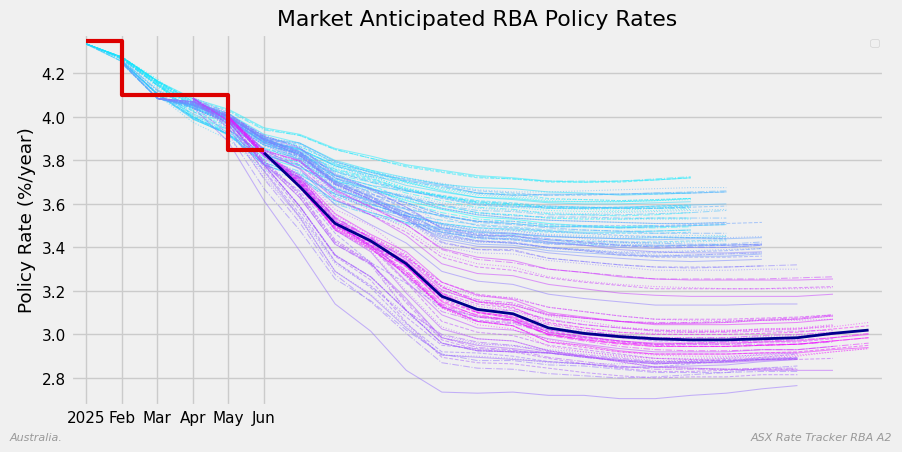

In [8]:
def plot_anticipated():
    """Plot daily ASX rate tracker implied market forecasts."""

    # plot the captured data from when ...
    startd = "2025-01-01"
    startm = startd[:7]

    # plot the ASX rate-tracker data
    data = df.T.copy().loc[startm:, startd:]
    anonymous = [f"_{x}" for x in data.columns]
    data.columns = anonymous
    num_columns = len(data.columns)
    colors = sns.color_palette("cool", num_columns)
    ax = mg.line_plot(
        data,
        width=0.75,
        color=colors,
        alpha=0.5,
    )

    # plot the most recent ASX data on a thicker line
    final = data[data.columns[-1]]
    final.name = "Most recent data"
    mg.line_plot(
        final,
        ax=ax,
        width=2,
        color="darkblue",
    )

    # plot the RBA OCR
    rba = ra.read_rba_ocr(monthly=True)
    rba.name = "RBA Official Cash Rate"
    mg.line_plot_finalise(
        rba[startm:],
        ax=ax,
        color="#dd0000",
        width=3,
        drawstyle="steps-post",
        title="Market Anticipated RBA Policy Rates",
        ylabel="Policy Rate (%/year)",
        lfooter=LFOOTER,
        rfooter=f"{RFOOTER} RBA A2",
        legend={"loc": "best", "fontsize": "x-small"},
        show=True,
    )


plot_anticipated()

## Monthly against RBA rate


In [9]:
def plot_against_rba():
    """Plot end of month ASX rate tracker forecasts against RBA cash rate.
    Limit to end of month to declutter the plot."""

    # Get end-of-month ASX forecast data
    asx_data = df.copy()
    asx_data.index = pd.PeriodIndex(asx_data.index, freq="M")
    drops = asx_data.index.duplicated(keep="last")
    asx_data = asx_data[~drops].T

    # plot the ASX data with a different colour for each column
    num_columns = len(asx_data.columns)
    colors = sns.color_palette("cool", num_columns)
    ax = asx_data.plot(color=colors, lw=1)

    # Get and plot the RBA data
    ocr = ra.read_rba_ocr()["2022-01":]
    ax = ocr.plot(
        ax=ax,
        color="darkred",
        lw=2.5,
        label="RBA Official Cash Rate",
        drawstyle="steps-post",
    )

    # finalise the plot
    mg.finalise_plot(
        ax,
        title="End of Month Market Anticipated RBA Policy Rates",
        ylabel="Policy Rate (%/year)",
        y0=True,
        zero_y=True,
        lfooter=LFOOTER,
        rfooter=f"{RFOOTER} RBA A2",
        legend={"loc": "lower center", "fontsize": "xx-small", "ncols": 4},
        show=SHOW,
    )


plot_against_rba()

/Users/bryanpalmer/ABS/.venv/lib/python3.13/site-packages/mgplot/finalise_plot.py:284: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(pad=1.1)


In [10]:
def endpoint_comparison():
    """Compare the endpoint forecast against the actual RBA rate."""

    # Endpoint rate against the actual RBA rate
    endpoint = df.copy().T.ffill().iloc[-1]
    endpoint.index += int(365 * 3 / 2)  # 18 months in days
    rba = ra.read_rba_ocr(monthly=False)["2022-01-01":].astype(float)
    ax = endpoint.plot(label="ASX Rate Tracker 18 month endpoint-forecast", lw=2)
    rba.plot(ax=ax, label="RBA Cash Rate", lw=2, color="red", drawstyle="steps-post")
    mg.finalise_plot(
        ax,
        title="Market 18 Month Endpoint Forecast vs RBA Cash Rate",
        ylabel="Policy Rate (%/year)",
        y0=True,
        zero_y=True,
        lfooter=LFOOTER,
        rfooter=f"{RFOOTER} RBA A2",
        legend={"loc": "best", "fontsize": "x-small"},
        show=SHOW,
    )


endpoint_comparison()

## Cut when

In [11]:
def plot_next_cut():
    """Plot the next anticipated rate cut."""

    # possibility of a cut below the current rate?
    start = "2023-11-28"
    start_p = pd.Period(start, freq="M")

    df_cuts = df.loc[start:].dropna(how="all", axis=1)
    labels = [
        f"{x}" for x in pd.period_range(start=start, end=df_cuts.columns[-1], freq="M")
    ]
    when = df_cuts.apply(lambda x: x + 0.25 <= daily_rba_ocr[x.index], axis=0)
    whence = when.T.idxmax().where(when.T.any(), other=np.nan)
    once = pd.Series(
        [c.n if not pd.isnull(c) else np.nan for c in (whence - start_p)],
        index=whence.index,
        name="Months to Cut",
    )
    mini, maxi = int(once.min()), int(once.max())
    labs = labels[mini : maxi + 1]
    ax = once.plot(lw=2)
    ax.set_yticks(range(mini, maxi + 1))
    ax.set_yticklabels(labs)
    mg.finalise_plot(
        ax,
        title="Next fully anticipated RBA Rate Cut",
        ylabel="Year-Month of the first\nanticipated cut",
        lfooter=f"{LFOOTER} When the market fully anticipates a 25bp cut "
        + "from the current RBA official interest rate. ",
        rfooter=f"Calculated from {RFOOTER}, RBA A2",
        show=SHOW,
    )


plot_next_cut()

## Finished

In [12]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Jun 18 2025 21:47:24

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

seaborn   : 0.13.2
dateutil  : 2.9.0.post0
pathlib   : 1.0.1
typing    : 3.10.0.0
readabs   : 0.0.31
mgplot    : 0.2.0
numpy     : 2.3.0
matplotlib: 3.10.3
pandas    : 2.3.0

Watermark: 2.5.0

